# Encoded Processed Data


This Notebook take the processed data instance & encodes the data to prepare for anaylsis, some additional clean may also be performed.

The idea is for these functions to be used when training the models.


#### Function
Abstracted class to process raw data.

#### Input
- file path: processed data instance 
- file path: write path

#### Output
- stored class hosting the processed data.

> Note: The **Encoding** class inherits all methods & properties from it's parent class: _batch_processing_.

---------
```
Zach Wolpe
zachcolinwolpe@gmail.com
15 June 2021
```
---------

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import torch
import sys
from tqdm import tqdm
import pickle
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 4000

# ---- load data module ----x
import sys
sys.path.append('')
from process_raw_data import batch_processing 

In [87]:
# ---- fetch data object ----x
with open('../data objects/batch_processing_object.pkl', 'rb') as file2:
    bp = pickle.load(file2)
bp.__dict__.keys()

dict_keys(['path', 'metadata', 'mapping', 'data_times', 'participants', 'parti_code', 'n', 'wcst_paths', 'nback_paths', 'corsi_paths', 'fitts_paths', 'navon_paths', 'wcst_data', 'nback_data', 'corsi_data', 'fitts_data', 'navon_data', 'individual_data', 'MTurk'])

In [88]:
bp.describe_data()



        ------------------------------------------------------------------
            self.path            : raw data loc
            self.metadata        : mturk metadata
            self.mapping         : reference table
            self.data_times      : reference times table
            self.participants    : list of participant identifiers
            self.parti_code      : list of participant codes
            self.n               : total number of samples
            self.wcst_paths      : paths to wcst  raw data
            self.nback_paths     : paths to nback raw data
            self.corsi_paths     : paths to corsi raw data
            self.fitts_paths     : paths to fitts raw data
            self.navon_paths     : paths to navon raw data
            self.wcst_data       : wcst  dataframe
            self.nback_data      : nback dataframe
            self.corsi_data      : corsi dataframe
            self.fitts_data      : fitts dataframe
            self.navon_data    

In [89]:
class encode_data:
    def __init__(self, bp):
        self.raw = bp

        # ---- fitts ----x
        bp.fitts_data['delta']      = bp.fitts_data['fitts_prediction'] - bp.fitts_data['reaction_time_ms']
        self.fitts_summary_stats    = bp.fitts_data.groupby(['participant']).agg({
            'delta': ['mean', 'std'], 'status': ['mean', 'std']}).reset_index()

        # ---- corsi ----x 
        self.corsi_summary_stats = bp.corsi_data.groupby(['participant']).agg(
            {'highest_span': ['max'], 'n_items': ['max'], 'status': ['mean', 'std']}).reset_index()

        # ---- navon ----x 
        x = bp.navon_data
        x['correct']  = x['status'] == 1
        x['too_slow'] = x['status'] == 3
        x = x.groupby(['participant', 'level_of_target']).agg(
            {'correct': ['mean', 'std'],
            'too_slow': ['mean', 'std'],
            'reaction_time_ms': ['mean', 'std']
            })
        x = x.reset_index()
        self.navon_summary_stats = x

        # ---- nback ----x
        self.nback_summary_stats = self.raw.nback_data.groupby(['participant', 'block_number']).agg({
            'trial_counter':    ['count'],
            'score':            ['mean', 'std'],
            'status':           ['mean', 'std'],
            'miss':             ['mean', 'std'],
            'false_alarm':      ['mean', 'std'],
            'reaction_time_ms': ['mean', 'std']
        }).reset_index()



        # ------- Demographics Encoding --------x
        # q: Gender
        # - male
        # - female
        # - other
        # - prefer not to say

        # q: Handedness
        # - right
        # - left
        # - ambidextrous

        # q: What is your highest level of education?
        # - primary school
        # - high school
        # - university
        # - graduate school

        # l: income
        # q: Compared with the average, what is your income on a scale from 1 to 10 with 5 being average?
        # - {min=1,max=10,left=low,right=high,start=5}

        # l: computer_hours
        # q: How many hours do you spend playing computer games (per week)
        # - {min=0,max=100,left=low,right=high,start=0}

        df = bp.individual_data[['participant', 'participant_file', 'user_agent', 'Welcome_Screen_T', 'participant_code_a', 'feedback_T', 'age_T', 'age_a', 'gender_T', 'gender_a',
                                'handedness_T', 'handedness_a', 'education_T', 'education_a', 'income_T', 'income_a', 'income_s', 'computer_hours_T', 
                                'computer_hours_a', 'computer_hours_s']]

        # ---- extract clean data ----x
        df             = df[df['age_a'].replace(np.NaN, 'na').str.isnumeric()]          # remove nonsensical data
        df.iloc[:, 3:] = df.iloc[:, 3:].astype('float')                                 # convert to float
        df             = df[df['gender_a'].notnull()]                                   # Nan data

        # ---- create age groupings ----x
        bins            = [0, 25, 35, 45, 55, 65, 120]
        labels          = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
        df['age_group'] = pd.cut(df['age_a'], bins, labels=labels, include_lowest=True)

        # ---- gender ----x
        df['gender_a'][df['gender_a'] == 1] = 'male'
        df['gender_a'][df['gender_a'] == 2] = 'female'
        df['gender_a'][df['gender_a'] == 3] = 'other'
        df['gender_a'][df['gender_a'] == 4] = 'other'

        # ---- handedness ----x
        df['handedness_a'][df['handedness_a'] == 1] = 'right'
        df['handedness_a'][df['handedness_a'] == 2] = 'left'
        df['handedness_a'][df['handedness_a'] == 3] = 'ambidextrous'

        # ---- education ----x
        df['education_a'][df['education_a'] == 1] = 'primary school'
        df['education_a'][df['education_a'] == 2] = 'high school'
        df['education_a'][df['education_a'] == 3] = 'university'
        df['education_a'][df['education_a'] == 4] = 'graduate school'

        self.demographics_plot = df
        # --- demographics dataset: clean ---x
        df2 = df[['participant', 'age_a','gender_a','handedness_a','education_a', 'income_a', 'computer_hours_a','age_group']]
        df2_times = df[['participant', 'feedback_T', 'age_T', 'gender_T','handedness_T', 'education_T', 'income_T', 'computer_hours_T']]
        df2_times['mean_reation_time_ms'] = df2_times.iloc[:,1:].mean(axis=1)
        df2_times = df2_times[['participant', 'mean_reation_time_ms']].set_index('participant')
        self.demographics = df2.set_index('participant').join(df2_times).reset_index()
        # ------- Demographics Encoding --------x

    
    def describe_data(self):
        """Describe the available data associated with the class"""
        message = """

        ------------------------------------------------------------------
            self.path            : raw data loc
            self.metadata        : mturk metadata
            self.mapping         : reference table
            self.data_times      : reference times table
            self.participants    : list of participant identifiers
            self.parti_code      : list of participant codes
            self.n               : total number of samples
            self.wcst_paths      : paths to wcst  raw data
            self.nback_paths     : paths to nback raw data
            self.corsi_paths     : paths to corsi raw data
            self.fitts_paths     : paths to fitts raw data
            self.navon_paths     : paths to navon raw data
            self.wcst_data       : wcst  dataframe
            self.nback_data      : nback dataframe
            self.corsi_data      : corsi dataframe
            self.fitts_data      : fitts dataframe
            self.navon_data      : navon dataframe
            self.individual_data : psytoolkit metadata
            self.MTurk           : mturk completion data

            -----------------------------------------------------
            Additions:

            self.raw                    : original object
            self.nback_summary_stats    : dataframe
            self.navon_summary_stats    : dataframe
            self.corsi_summary_stats    : dataframe
            self.fitts_summary_stats    : dataframe
            self.demographics           : dataframe
            self.plot_random_fitts      : plot
            self.plot_corsi             : plot
            self.plot_navon             : plot
            self.write_class_to_pickle  : function
            self.describe_data          : info
            self.clean_data_info        : info
            
        ------------------------------------------------------------------

        """
        print(message)

    def clean_data_info(self):
        """Describe the details of the summary datasets"""
        message = """

            ===========================================================================================================================
                WCST - Wisconsin Card Sorting Task                                                  DataFrame: ed.raw.wcst_date
            ---------------------------------------------------------------------------------------------------------------------------
            
                participant                     : key               : participant ID
                card_no                         : categorical       : the card shown
                correct_card                    : categorical       : the card that should be clicked of the top four on screen      
                correct_persevering             : categorical       : the card that would be clicked if the participant is persevering
                seq_no                          : numeric           : trial number
                rule                            : categorical       : matching rule  
                card_shape                      : categorical       : current card shape
                card_number                     : categorical       : current card number
                card_colour                     : categorical       : current card colour
                reaction_time_ms                : numeric           : reaction time (ms)
                status                          : categorical       : 1=correct, 2=wrong card, 3=too slow
                card_selected                   : categorical       : card chosen
                error                           : binary            : 1=error, 0=no error
                perseverance_error              : binary            : 1=perserverance error,       0=otherwise
                not_perseverance_error          : binary            : 1=not a perseveration error, 0=otherwise

            ---------------------------------------------------------------------------------------------------------------------------    
                Demographic                                                                         DataFrame: ed.demographics
            ---------------------------------------------------------------------------------------------------------------------------

                participant                     : key 
                age_a                           : numeric
                gender_a                        : categorical 
                handedness_a                    : categorical
                education_a                     : categorical
                income_a                        : categorical 
                computer_hours_a                : numeric
                age_group                       : categorical
                mean_reation_time_ms.           : numeric

            ---------------------------------------------------------------------------------------------------------------------------    
                N-Back                                                                              DataFrame: ed.nback_summary_stats
            ---------------------------------------------------------------------------------------------------------------------------

                participant                     : key 
                block_number                    : numeric       : trial block number 
                trial_counter   - count         : numeric       : number of trials in the block 
                score           - mean          : probability   : score of current trail (1=correct, 0=wrong)
                                - std           : probability       
                status          - mean          : probability   : whether the response given was a correct match (1=correct, 0=wrong)
                                - std           : probability   
                miss            - mean          : probability   : whether the response given was a miss (1=miss, 0=otherwise)
                                - std           : probability     
                false_alarm     - mean          : probability   : 1=participant clicked but there was no-match, 0=otherwise
                                - std           : probability    
                reaction_time_ms- mean          : numeric       
                                - std           : numeric  

            ---------------------------------------------------------------------------------------------------------------------------    
                Navon                                                                              DataFrame: ed.nback_summary_stats
            ---------------------------------------------------------------------------------------------------------------------------

                participant                     : key 
                level_of_target                 : categorical   : type of signal (global/local/none)
                correct         - mean          : probability   : correct action
                                - std           : probability
                too_slow        - mean          : probability   : acted too slow
                                - std           : probability
                reaction_time_ms- mean
                                - std

            ---------------------------------------------------------------------------------------------------------------------------    
                Corsi Block Span                                                                    DataFrame: ed.corsi_summary_stats
            ---------------------------------------------------------------------------------------------------------------------------

                participant                     : key 
                highest_span    - max           : numeric       : highest corsi block span
                n_items         - max           : numeric       : (max) number of items to be remembered
                status          - mean          : probability   : current trial (1=correct, 0=wrong)
                                - std           : probability 

            ---------------------------------------------------------------------------------------------------------------------------    
                Fitts Law                                                                          DataFrame: ed.fitts_summary_stats
            ---------------------------------------------------------------------------------------------------------------------------

                participant                     : key 
                delta           - mean          : numeric       : average deviation in expects (fitts law) performance
                                - std           : numeric       : std dev in expected (fitts law) performance
                status          - mean          : numeric       : status (1=correct, 2=error, 3=too slow)
                                - std           : numeric     
                                
            ===========================================================================================================================
        """
        print(message)



    def plot_random_fitts(self, all=False, color='lightblue'):
        x = self.raw.fitts_data
        p = np.random.choice(x.participant.unique())
        if not all:
            x.loc[x['participant'] == p,].hist('delta', bins=20, color=color)
            plt.title(f'Participant: {round(p)}')
            plt.axvline(x.loc[x['participant'] == p, ['delta']].mean()[0], color='#e390ba', linewidth=2, linestyle='--')
            plt.xlabel('Fitts Delta')
        else:       
            x.loc[:, ['delta']].hist(bins=20, color=color)
            plt.axvline(x.loc[:, ['delta']].mean()[0], color='maroon', linestyle='--')
            plt.title('All Participants')
        plt.xlabel('Fitts Delta')


    def plot_corsi(self, color='#00a0b0'):
        x = self.corsi_summary_stats
        x.highest_span.hist(label='Corsi Span', color=color)
        xbar = x['highest_span'].mean()[0]
        plt.axvline(xbar, color='#ff8cb9', linestyle='--', linewidth=2, label=f'mean: {xbar}')
        plt.legend()
        plt.title('Corsi Block Span')
        plt.ylabel('frequency')
        plt.xlabel('Corsi Block Span')
        plt.show()


    def plot_navon(self, color='#6f235f'):
        self.navon_summary_stats.hist(color=color)
        plt.tight_layout()
        plt.show()


    def pie_chart(self, dummy_var, labels, colors, title, df=None):
        if not df: df=self.demographics
        sub    = df[[dummy_var]].value_counts()
        values = sub.tolist()
        fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
        fig.update_traces(textfont_size=15, marker=dict(colors=colors, line=dict(color='white', width=0)))
        fig.update(layout_title_text=title)
        fig.show()
        
    def distributional_plots(self, continuous_var, cat_var, categories, labels, colors, xlab, ylab, title, df=None):
        if not df: df=self.demographics_plot
        fig = go.Figure()
        for c in range(len(categories)):
            fig.add_trace(go.Histogram(
                x           =df[continuous_var][df[cat_var] == categories[c]],
                # histnorm    ='percent',
                name        =labels[c], 
                marker_color=colors[c],
                opacity     =1
            ))
        fig.update_layout(
            barmode         ='overlay',
            title_text      =title, 
            xaxis_title_text=xlab, 
            yaxis_title_text=ylab, 
            bargap          =0.05, 
            bargroupgap     =0.1 
        )
        fig.update_layout(barmode='group')
        fig.show()



    def write_class_to_pickle(self, path):
        """serialize object to pickle object"""

        #save it
        filename = path + 'batch_processing_object_with_encodings.pkl'
        with open(filename, 'wb') as file:
            pickle.dump(self, file) 

        # #load it
        # with open(filename, 'rb') as file2:
        #     bp = pickle.load(file2)
        message="""
        ------------------------------------------------------------------
        Object successfully written to path: \'{}\'!

        To retrieve run:
            with open(\'{}\', 'rb') as file2:
                bp = pickle.load(file2)
        ------------------------------------------------------------------
        """.format(filename, filename)
        print(message)



In [90]:
ed = encode_data(bp)
plt.style.use('default')
write_path = '../data objects/'
ed.write_class_to_pickle(write_path)


        ------------------------------------------------------------------
        Object successfully written to path: '../data objects/batch_processing_object_with_encodings.pkl'!

        To retrieve run:
            with open('../data objects/batch_processing_object_with_encodings.pkl', 'rb') as file2:
                bp = pickle.load(file2)
        ------------------------------------------------------------------
        


In [85]:
ed.describe_data()



        ------------------------------------------------------------------
            self.path            : raw data loc
            self.metadata        : mturk metadata
            self.mapping         : reference table
            self.data_times      : reference times table
            self.participants    : list of participant identifiers
            self.parti_code      : list of participant codes
            self.n               : total number of samples
            self.wcst_paths      : paths to wcst  raw data
            self.nback_paths     : paths to nback raw data
            self.corsi_paths     : paths to corsi raw data
            self.fitts_paths     : paths to fitts raw data
            self.navon_paths     : paths to navon raw data
            self.wcst_data       : wcst  dataframe
            self.nback_data      : nback dataframe
            self.corsi_data      : corsi dataframe
            self.fitts_data      : fitts dataframe
            self.navon_data    

# Relational Database

These functions have allowed us to create a relational database where the foreign keys are the participant codes.

Here we examine the available data:

In [69]:
ed.nback_summary_stats.head()

participant block_number trial_counter score              status            \
                                   count  mean       std      mean       std   
0    100934.0            1            20  0.30  0.470162  0.850000  0.366348   
1    100934.0            2            30  0.30  0.466092  0.900000  0.305129   
2    100934.0            3            30  0.20  0.406838  0.933333  0.253708   
3    103322.0            1            20  0.25  0.444262  0.850000  0.366348   
4    103322.0            2            30  0.30  0.466092  0.933333  0.253708   

       miss           false_alarm           reaction_time_ms               
       mean       std        mean       std             mean          std  
0  0.250000  0.444262    0.050000  0.223607      2155.400000  1185.698080  
1  0.266667  0.449776    0.033333  0.182574      2175.133333  1191.591626  
2  0.200000  0.406838    0.000000  0.000000      2323.700000  1142.043364  
3  0.200000  0.410391    0.050000  0.223607      2305.100000  1090.350542  
4  0.233333  0.430183    0.066667  0.253708      2425.966667  1059.981668

In [70]:
ed.navon_summary_stats.head() 

participant level_of_target   correct           too_slow       \
                                   mean       std     mean  std   
0    100934.0          global  0.166667  0.389249      0.0  0.0   
1    100934.0           local  0.461538  0.518875      0.0  0.0   
2    100934.0            none  0.480000  0.509902      0.0  0.0   
3    103322.0          global  0.923077  0.277350      0.0  0.0   
4    103322.0           local  0.916667  0.288675      0.0  0.0   

  reaction_time_ms              
              mean         std  
0       664.583333  221.989540  
1       597.769231  294.353856  
2       622.960000  343.110949  
3       959.769231  358.604739  
4       999.750000  221.561453

In [71]:
ed.corsi_summary_stats.head()

participant highest_span n_items    status          
                       max     max      mean       std
0    100934.0            4       5  0.428571  0.534522
1    103322.0            6       7  0.625000  0.517549
2    107700.0            6       7  0.625000  0.517549
3    117200.0            4       5  0.500000  0.547723
4    117306.0            5       6  0.571429  0.534522

In [72]:
ed.fitts_summary_stats.head()

participant   delta             status          
                 mean         std   mean       std
0    100934.0   -5.70  186.607130    1.0  0.000000
1    103322.0 -203.05  174.308400    1.0  0.000000
2    107700.0 -342.65  345.637059    1.1  0.447214
3    117200.0  -85.05  156.117188    1.0  0.000000
4    117306.0 -141.80  167.808036    1.0  0.000000

In [73]:
ed.demographics.head()

,participant,age_a,gender_a,handedness_a,education_a,income_a,computer_hours_a,age_group,mean_reation_time_ms
0,816404.0,28.0,female,right,university,6.0,20.0,25-34,5502.000000
1,221478.0,25.0,female,right,graduate school,7.0,60.0,18-24,12353.428571
2,192208.0,29.0,male,right,university,6.0,5.0,25-34,8302.285714
3,803102.0,47.0,male,right,university,7.0,74.0,45-54,10340.857143
4,844810.0,32.0,female,right,university,6.0,22.0,25-34,6612.428571


# Base Plots

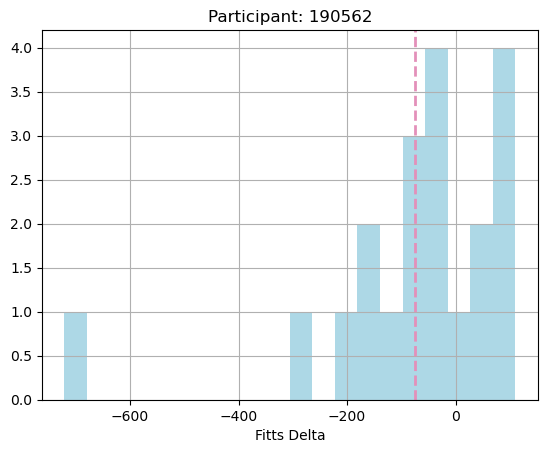

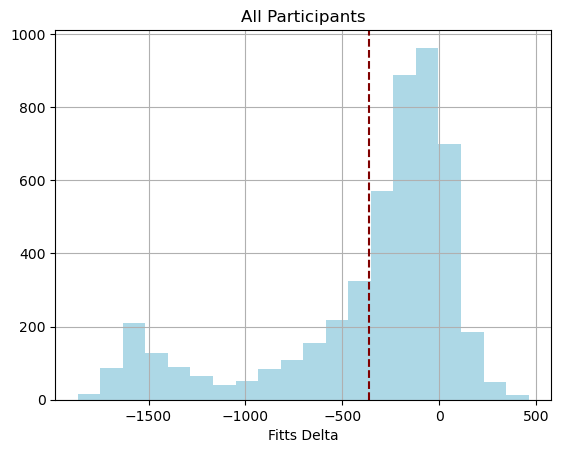

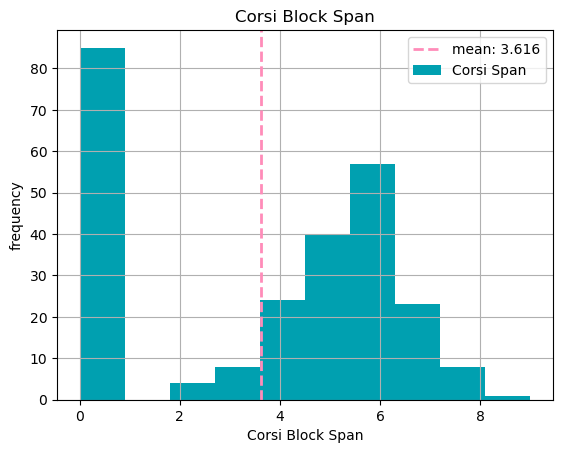

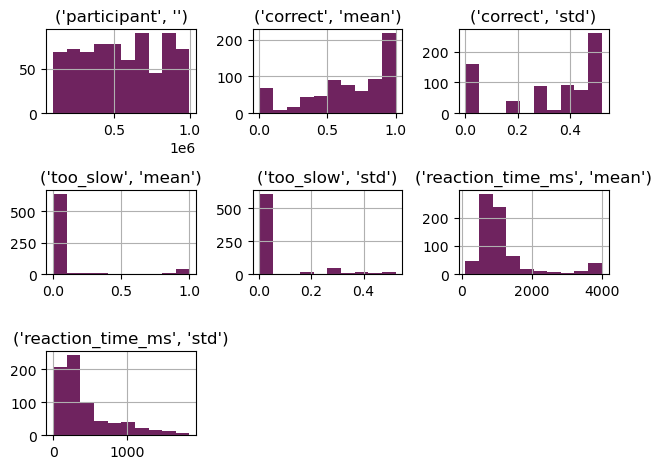

In [74]:
ed.plot_random_fitts(all=False)
ed.plot_random_fitts(all=True)
ed.plot_corsi()
ed.plot_navon()

# Demographics Data

# Categorical Distributions

In [75]:
# ---- gender pie plot ----x
ed.pie_chart(dummy_var='gender_a', labels=['male', 'female', 'other'], colors=['steelblue', 'cyan', 'darkred'], title='Gender Distribution')

# ---- gender pie plot ----x
ed.pie_chart(dummy_var='education_a', labels=['university', 'graduate school', 'high school'], title='Education Distribution',
    colors=['rgb(177, 127, 38)', 'rgb(129, 180, 179)', 'rgb(205, 152, 36)'])

# ---- handedness pie plot ----x
ed.pie_chart(dummy_var='handedness_a', labels=['right', 'left', 'ambidextrous'], title='Handedness Distribution', colors=px.colors.sequential.RdBu)

# ---- age distribution ----x
ed.pie_chart(dummy_var='age_group', labels=np.unique(ed.demographics[['age_group']]).tolist(), title='Age Distribution', colors=px.colors.sequential.GnBu)

# Continuous Variable Dsitributions

In [76]:
# ---- Age Distribution ----x
ed.distributional_plots(
    continuous_var='age_a', cat_var='gender_a', categories=['male', 'female'], labels=['male', 'female'], colors=['lightblue', 'pink'], 
    xlab='Age', ylab='Count', title='Age Distribution (by gender)')

# ---- Income Distribution ----x
ed.distributional_plots(
    continuous_var='income_a', cat_var='gender_a', categories=['male', 'female'], labels=['male', 'female'], colors=['lightblue', 'pink'], 
    xlab='Income', ylab='Count', title='Income Distribution (by gender)')

# ---- Computer Hours Distribution ----x
ed.distributional_plots(
    continuous_var='computer_hours_a', cat_var='gender_a', categories=['male', 'female'], labels=['male', 'female'], colors=['lightblue', 'pink'], 
    xlab='Computer Hours', ylab='Count', title='Computer Hours Distribution (by gender)')

In [77]:
# ---- Age Distribution ----x
ed.distributional_plots(
    continuous_var='age_a', cat_var='education_a', categories=ed.demographics['education_a'].unique(), labels=ed.demographics['education_a'].unique(), 
    colors=['#00537a', '#ffa9bc', '#8fe1ff', '#0a75ad'], 
    xlab='Age', ylab='Count', title='Age Distribution (by education)')

# ---- Income Distribution ----x
ed.distributional_plots(
    continuous_var='income_a', cat_var='education_a', categories=ed.demographics['education_a'].unique(), labels=ed.demographics['education_a'].unique(),
    colors=['#00537a', '#ffa9bc', '#8fe1ff', '#0a75ad'], 
    xlab='Income', ylab='Count', title='Income Distribution (by education)')

# ---- Computer Hours Distribution ----x
ed.distributional_plots(
    continuous_var='computer_hours_a', cat_var='education_a', categories=ed.demographics['education_a'].unique(), labels=ed.demographics['education_a'].unique(), 
    colors=['#00537a', '#ffa9bc', '#8fe1ff', '#0a75ad'], 
    xlab='Computer Hours', ylab='Count', title='Computer Hours Distribution (by education)')

In [78]:
# ---- Age Distribution ----x
ed.distributional_plots(
    continuous_var='age_a', cat_var='handedness_a', categories=ed.demographics['handedness_a'].unique(), labels=ed.demographics['handedness_a'].unique(), 
    colors=px.colors.sequential.GnBu, 
    xlab='Age', ylab='Count', title='Age Distribution (by handedness)')

# ---- Income Distribution ----x
ed.distributional_plots(
    continuous_var='income_a', cat_var='handedness_a', categories=ed.demographics['handedness_a'].unique(), labels=ed.demographics['handedness_a'].unique(), 
    colors=px.colors.sequential.GnBu, 
    xlab='Income', ylab='Count', title='Income Distribution (by handedness)')

# ---- Computer Hours Distribution ----x
ed.distributional_plots(
    continuous_var='computer_hours_a', cat_var='handedness_a', categories=ed.demographics['handedness_a'].unique(), labels=ed.demographics['handedness_a'].unique(), 
    colors=px.colors.sequential.GnBu, 
    xlab='Computer Hours', ylab='Count', title='Computer Hours Distribution (by handedness)')

In [79]:
# ---- Age Distribution ----x
ed.distributional_plots(
    continuous_var='age_a', cat_var='age_group', categories=np.unique(ed.demographics[['age_group']]).tolist(), labels=np.unique(ed.demographics[['age_group']]).tolist(), 
    colors=px.colors.sequential.RdBu, 
    xlab='Age', ylab='Count', title='Age Distribution (by age_group)')

# ---- Income Distribution ----x
ed.distributional_plots(
    continuous_var='income_a', cat_var='age_group', categories=np.unique(ed.demographics[['age_group']]).tolist(), labels=np.unique(ed.demographics[['age_group']]).tolist(), 
    colors=px.colors.sequential.RdBu, 
    xlab='Income', ylab='Count', title='Income Distribution (by age_group)')

# ---- Computer Hours Distribution ----x
ed.distributional_plots(
    continuous_var='computer_hours_a', cat_var='age_group', categories=np.unique(ed.demographics[['age_group']]).tolist(), labels=np.unique(ed.demographics[['age_group']]).tolist(), 
    colors=px.colors.sequential.RdBu, 
    xlab='Computer Hours', ylab='Count', title='Computer Hours Distribution (by age_group)')